Import the libraries

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

In [5]:
content_path='/content/content.jpg'
style_path = '/content/style.jpg'

In [6]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.LANCZOS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0)

    return im_array

  # The function load_file takes an image path as input, opens the image, resizes it to ensure its maximum dimension is 512 pixels while maintaining the aspect ratio, converts the resized image to a NumPy array, adds an extra dimension to make it suitable for batch processing, and returns the resulting array.

In [7]:
def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)

# The show_im function is intended to display an image using Matplotlib. It:

# Removes the batch dimension from the image array (if present).
# Displays the image.
# Sets an optional title for the image.


In [8]:
content = load_file(content_path)
style = load_file(style_path)

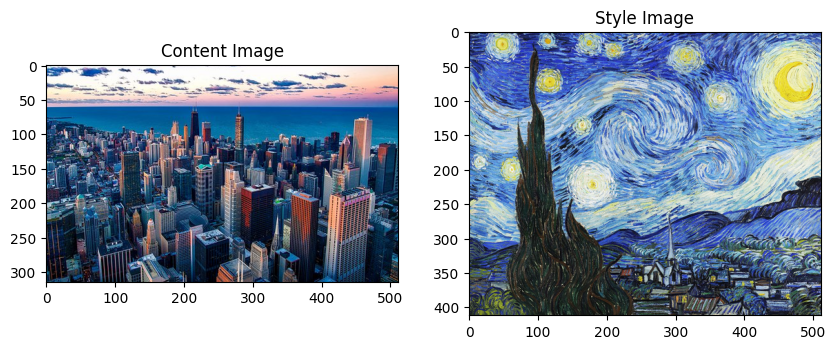

In [9]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

In [10]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

# The img_preprocess function loads an image from a specified path, preprocesses it using the VGG19-specific preprocessing function, and returns the preprocessed image. This is necessary to ensure the image data is in the correct format and scale expected by the VGG19 neural network.

In [11]:
# The mean values (which were subtracted during preprocessing) are added back to the respective channels. The mean values for the VGG19 model are 103.939 for the Blue channel, 116.779 for the Green channel, and 123.68 for the Red channel.
# The channels are reordered from BGR to RGB using x[:, :, ::-1] since VGG19 expects BGR input but typical image visualization uses RGB.


def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]


  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x


# The deprocess_img function takes an image that has been preprocessed for the VGG19 model and converts it back to a displayable format by reversing the preprocessing steps.


In [13]:
im=img_preprocess(content_path)  #This will preprocess image content_path for use with the VGG19 model.



In [14]:
# Content Features: Typically extracted from higher layers of the network, as they contain high-level information about the objects and their arrangement in the image. The layer block5_conv2 is chosen for this purpose.
# Style Features: Typically extracted from multiple layers (both lower and higher) to capture different levels of patterns and textures. The layers block1_conv1 to block5_conv1 are chosen to capture a wide range of stylistic details.
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

In [15]:
# The get_model function constructs a modified VGG19 model that outputs both style and content features from specified layers. This model can be used in neural style transfer to extract features from an image for both style and content, allowing you to blend the style of one image with the content of another
def get_model():

    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')  #loads the VGG19 model pre-trained on the ImageNet dataset.
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]    #vgg.get_layer(layer).output retrieves the output of the specified layer.
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output   #creating a new model that takes the same input as the VGG19 model but outputs the combined list of style and content features
    return models.Model(vgg.input,model_output)

In [16]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()   #tell about the architecture of the vgg 19 model

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [17]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss
    # tf.square(noise - target): Computes the element-wise squared difference between noise and target.

In [18]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])  #gives the number of channels/features in the tensor.(batch_size, height, width, channels)
    vector=tf.reshape(tensor,[-1,channels])   #reshapes the tensor into a 2D matrix where each row corresponds to a flattened spatial position across all channels.
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

# The gram_matrix function calculates the Gram matrix for a given tensor, which is often used in style transfer algorithms to capture style information from feature maps of convolutional neural networks.

In [19]:
# calculates the style loss between a generated image (noise) and a target image
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

In [20]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)

    content_output=model(content_img)
    style_output=model(style_image)

    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature

In [21]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image

    output=model(image)
    content_loss=0
    style_loss=0

    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]

    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)


    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)

    style_loss *= style_weight
    content_loss *= content_weight

    total_loss = content_loss + style_loss


    return total_loss,style_loss,content_loss

In [22]:
#compute the gradients of the total loss with respect to the generated image (dictionary['image']) using TensorFlow's GradientTape.

def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)

    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

# Returns gradients (grads) that indicate the direction and magnitude of changes needed to minimize the total loss, along with all_loss containing detailed loss values for analysis or further processing.



In [23]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):

    model=get_model()

    for layer in model.layers:
        layer.trainable = False

    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]

    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss,best_img=float('inf'),None

    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)

        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())

         #for visualization

        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(best_img))
            print('Epoch: {}'.format(i))
            print('Total loss: {:.4e}, '
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))

    IPython.display.clear_output(wait=True)


    return best_img,best_loss,imgs

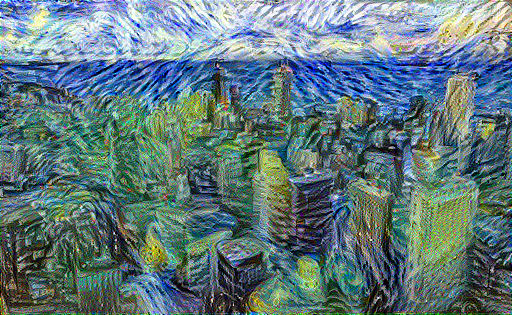

Epoch: 495
Total loss: 2.9348e+06, style loss: 9.0828e+05, content loss: 2.0265e+06, 


In [24]:
best, best_loss,image = run_style_transfer(content_path,
                                     style_path, epochs=500)